# Learning Curves, Validation Curves, and ROC

The learning curve, validation curve, and the ROC are three very useful graphical tools that help with the evaluation of a model. This module explains and demonstrates each one. 

## Learning Curves

Learning curves help us diagnose model bias or variance. The image below demonstrates what bias and variance would look like for at various sizes of a training dataset. As we can see, performance increases with increasing N, but not completely. 

<img src="extras/06_04.png" width="600" height="600" />

A learning curve plots training accuracy and validation accuracy as a function of training size. The gap between the two curves is what is going to help us identify overfitting. The bigger the gap, more likely that we have overfitting. 

We will be using the Breast Cancer Wisconsin dataset for our examples today.

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

Then we convert the target column from string to integer. 

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

Then we generate our test and training sets. 

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

Now we create the learning curve. 

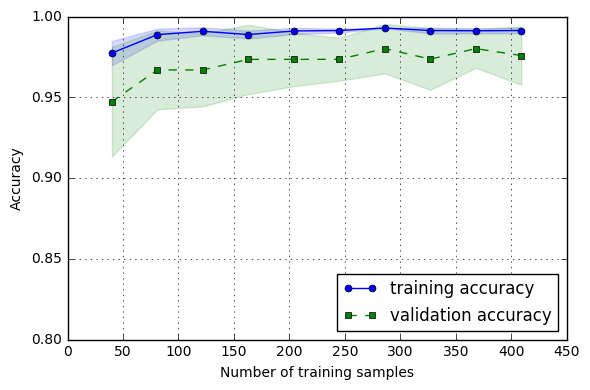

In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
%matplotlib inline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

Via the `train_sizes` parameter in the `learning_curve` function, we can control the absolute or relative number of training samples that are used to generate the learning curves. Here, we set `train_sizes`=np.linspace(0.1, 1.0, 10) to use 10 evenly spaced relative intervals for the training set sizes. By default, the learning_curve function uses stratified k-fold cross-validation to calculate the cross-validation accuracy, and we set k=10 via the `cv` parameter. Then, we simply calculate the average accuracies from the returned cross-validated training and test scores for the different sizes of the training set, which we plotted using matplotlib's plot function. Furthermore, we add the standard deviation of the average accuracies to the plot using the `fill_between` function to indicate the variance of the estimate.  

As we can see in the preceding learning curve plot, our model performs quite well on the test dataset. However, it may be slightly overfitting the training data indicated by a relatively small, but visible, gap between the training and cross-validation accuracy curves.

## Validation Curves

Validation curves are a useful tool for improving the performance of a model by addressing issues such as overfitting or underfitting. Validation curves are related to learning curves, but instead of plotting the training and test accuracies as functions of the sample size, we vary the values of the model parameters, for example, the inverse regularization parameter C in logistic regression.

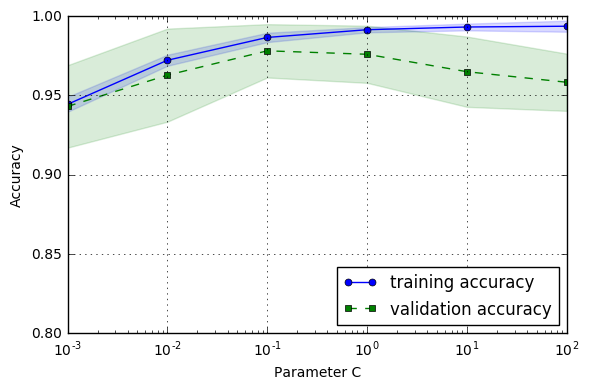

In [10]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

Similar to the `learning_curve` function, the `validation_curve` function uses stratified k-fold cross-validation by default to estimate the performance of the model if we are using algorithms for classification. Inside the `validation_curve` function, we specified the parameter that we wanted to evaluate. In this case, it is C, the inverse regularization parameter of the `LogisticRegression` classifier, which we wrote as `'clf\__C'` to access the `LogisticRegression` object inside the scikit-learn pipeline for a specified value range that we set via the `param_range` parameter. Similar to the learning curve example in the previous section, we plotted the average training and cross-validation accuracies and the corresponding standard deviations.  

Although the differences in the accuracy for varying values of C are subtle, we can see that the model slightly underfits the data when we increase the regularization strength (small values of C). However, for large values of C, it means lowering the strength of regularization, so the model tends to slightly overfit the data. In this case, the sweet spot appears to be around `C=0.1`.

## Receiver Operating Characteristic (ROC)

The receiver operating characteristic (ROC), or ROC curve, is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection[1] in machine learning. The false-positive rate is also known as the fall-out or probability of false alarm[1] and can be calculated as (1 − specificity). The ROC curve is thus the sensitivity as a function of fall-out. 

ROC analysis provides tools to select possibly optimal models and to discard suboptimal ones independently from (and prior to specifying) the cost context or the class distribution. ROC analysis is related in a direct and natural way to cost/benefit analysis of diagnostic decision making.

The TPR defines how many correct positive results occur among all positive samples available during the test. FPR, on the other hand, defines how many incorrect positive results occur among all negative samples available during the test.

A ROC space is defined by FPR and TPR as x and y axes respectively, which depicts relative trade-offs between true positive (benefits) and false positive (costs). Since TPR is equivalent to sensitivity and FPR is equal to 1 − specificity, the ROC graph is sometimes called the sensitivity vs (1 − specificity) plot. Each prediction result or instance of a confusion matrix represents one point in the ROC space.

The best possible prediction method would yield a point in the upper left corner or coordinate (0,1) of the ROC space, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives). The (0,1) point is also called a *perfect classification*. A completely random guess would give a point along a diagonal line (the so-called *line of no-discrimination*) from the left bottom to the top right corners (regardless of the positive and negative base rates). An intuitive example of random guessing is a decision by flipping coins (heads or tails). As the size of the sample increases, a random classifier's ROC point migrates towards (0.5,0.5).

The diagonal divides the ROC space. Points above the diagonal represent good classification results (better than random), points below the line represent poor results (worse than random). Note that the output of a consistently poor predictor could simply be inverted to obtain a good predictor.

In binary classification, the class prediction for each instance is often made based on a continuous random variable X, which is a "score" computed for the instance (e.g. estimated probability in logistic regression). Given a threshold parameter T, the instance is classified as "positive" if X>T, and "negative" otherwise. X follows a probability density f1(x) if the instance actually belongs to class "positive", and f0(x) if otherwise. Therefore, the true positive rate is given by 

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d4dc7e1e31aade00f2297d38315bd2ee0471acbf)

and the false positive rate is given by 

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/6daece3dcd331ed4eb8e7a0d0cd05741179aef77)

The ROC curve plots parametrically TPR(T) versus FPR(T) with T as the varying parameter.

![](extras/Receiver_Operating_Characteristic.png)

For example, imagine that the blood protein levels in diseased people and healthy people are normally distributed with means of 2 g/dL and 1 g/dL respectively. A medical test might measure the level of a certain protein in a blood sample and classify any number above a certain threshold as indicating disease. The experimenter can adjust the threshold (black vertical line in the figure), which will in turn change the false positive rate. Increasing the threshold would result in fewer false positives (and more false negatives), corresponding to a leftward movement on the curve. The actual shape of the curve is determined by how much overlap the two distributions have.

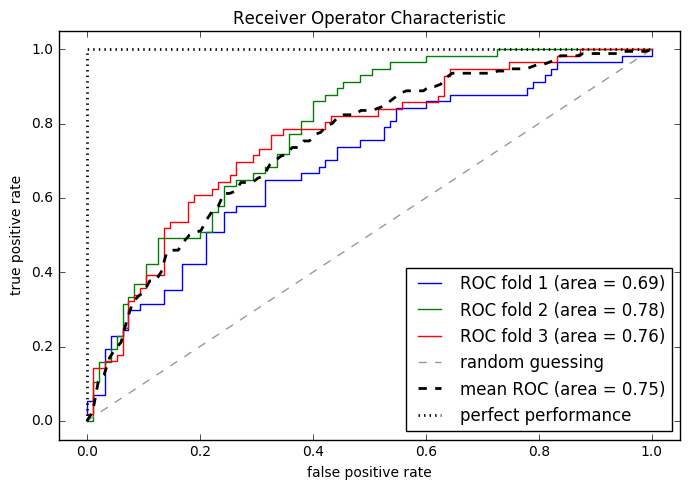

In [21]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedKFold

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]


cv = list(StratifiedKFold(y_train, n_folds=3, 
                              random_state=1))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

The basic way of plotting the ROC curve and measuring the AUC is illustrated here. 

roc_auc 0.99041005291


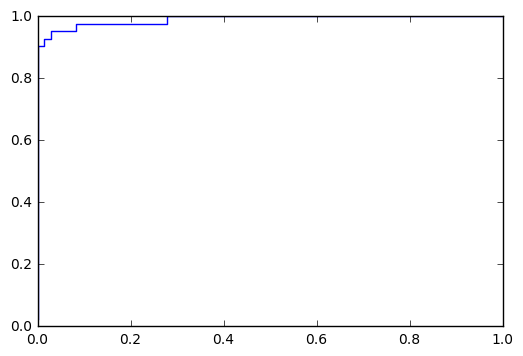

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

lr = LogisticRegression()
lr = lr.fit(X_train, y_train)
yhat = lr.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, yhat[:,1], pos_label=1)

print 'roc_auc', auc(fpr, tpr)
plt.plot(fpr, tpr)

## References

- Raschka, Sebastian. Python Machine Learning. Packt Publishing, 2015, Birmingham, UK.
- https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
- https://kennis-research.shinyapps.io/ROC-Curves/